### Konteks
Anda memiliki bisnis supermarket mall dan melalui kartu member, anda memiliki informasi dasar dari pelanggan anda seperti id pelanggan, umur, jenis kelamin, penghasilan tahunan, dan skor pengeluaran. Skor pengeluaran merupakan nilai yang didasarkan pada pendekatan heuristik berdasarkan perilaku konsumen dan data pembelian.

### Statmen Permasalahan
Anda memiliki bisnis supermarket dan ingin memahami konsumen anda dengan mengidentifikasi siapa saja konsumen yang berpotensi menjadi target konsumen dan menjadi insight bagi tim marketing anda untuk merencanakan strategi pemasaran dengan tepat.

### Data
Berikut adalah informasi yang anda miliki:
* customer_id : ID pelanggan
* gender : Jenis kelamin pelanggan
* age : Umur pelanggan
* annual_income : Penghasilan tahunan pelanggan dalam K$
* spending_score : Skor pengeluaran pelanggan berdasarkan perilaku konsumen dan data pembelian pada rentang 0-100

### Analisis
* Melakukan proses segmentasi sederhana dengan algoritma KMeans++
* Melakukan tracking pada pembuatan model dan ML artifact
* Meregister model
* Melakukan model staging ke stage production 
* Melakukan prediksi batch menggunakan model di stage production

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import os
os.environ['OMP_NUM_THREADS']='1'

import warnings
warnings.filterwarnings("ignore")

In [121]:
mlflow.set_tracking_uri("http://localhost:8001")
mlflow.set_experiment("customer_segmentation")

<Experiment: artifact_location='file:///mlflow/mlruns/3', experiment_id='3', lifecycle_stage='active', name='customer_segmentation', tags={}>

In [122]:
df = pd.read_csv('D:\mlflow\Backup\customer segmentation\Mall_Customers.csv')

In [123]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


In [124]:
df.shape

(200, 5)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     200 non-null    int64
 1   gender          200 non-null    int64
 2   age             200 non-null    int64
 3   annual_income   200 non-null    int64
 4   spending_score  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


In [126]:
X = df.iloc[:,[3,4]].values

In [127]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=30)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

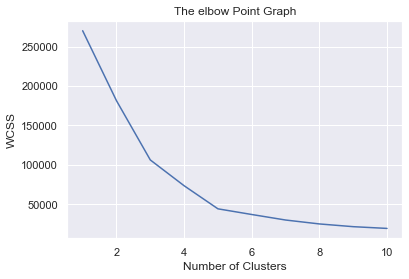

In [128]:
sns.set()
plt.plot(range(1,11), wcss)
plt.title('The elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig(fname='Elbow Plot')
plt.show()

In [129]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1).values

    def fit(self, X, y=None):
        return self 

[Pipeline] .... (step 1 of 2) Processing column_dropper, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.2s


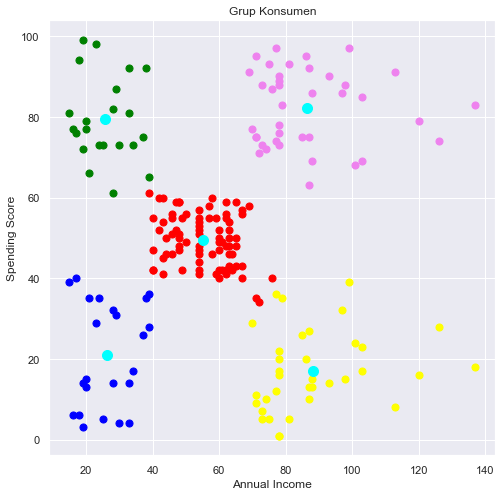

[Pipeline] .... (step 1 of 2) Processing column_dropper, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.2s


Registered model 'customer_segmentation_reg' already exists. Creating a new version of this model...
2022/07/27 05:06:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: customer_segmentation_reg, version 3
Created version '3' of model 'customer_segmentation_reg'.


In [130]:
mlflow.sklearn.autolog(log_input_examples=True, log_model_signatures=True, silent=True)
with mlflow.start_run(run_name="kmeans_5"):
    col_dropper = columnDropperTransformer(['customer_id', 'gender', 'age'])
    kmeans = KMeans(n_clusters=5,init='k-means++',random_state=30)

    pipeline = Pipeline(steps=[
        ("column_dropper", col_dropper),
        ("kmeans", kmeans)],
        verbose=True
    )

    Y = pipeline.fit_predict(df)

    plt.figure(figsize=(8,8))
    plt.scatter(X[Y==0,0],X[Y==0,1],s=50,c='green',label='Cluster 1')
    plt.scatter(X[Y==1,0],X[Y==1,1],s=50,c='red',label='Cluster 2')
    plt.scatter(X[Y==2,0],X[Y==2,1],s=50,c='yellow',label='Cluster 3')
    plt.scatter(X[Y==3,0],X[Y==3,1],s=50,c='violet',label='Cluster 4')
    plt.scatter(X[Y==4,0],X[Y==4,1],s=50,c='blue',label='Cluster 5')

    # plot the centroids
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],s=100, c='cyan',label='Centroids')
    plt.title('Grup Konsumen')
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    plt.savefig(fname='Cluster Plot')
    plt.show()

    mlflow.log_artifact(artifact_path="Grafik", local_path='D:\mlflow\Backup\customer segmentation\Cluster Plot.png')
    mlflow.log_artifact(artifact_path="Grafik", local_path='D:\mlflow\Backup\customer segmentation\Elbow Plot.png')

    signatures = infer_signature(df, pipeline.fit_predict(df))

    mlflow.sklearn.log_model(
        artifact_path='Model',
        sk_model = pipeline,
        signature = signatures,
        code_paths=['D:/mlflow/Backup/customer segmentation/test.ipynb'],
        registered_model_name = "customer_segmentation_reg"
        )

In [131]:
Y[0:4]

array([4, 0, 4, 0])

In [132]:
#interpreter
client = MlflowClient()
client.transition_model_version_stage(
    name="customer_segmentation_reg",
    version=2,
    stage="None"
)

client.transition_model_version_stage(
    name="customer_segmentation_reg",
    version=3,
    stage="Production"
)

<ModelVersion: creation_timestamp=1658873194369, current_stage='Production', description='', last_updated_timestamp=1658873194637, name='customer_segmentation_reg', run_id='35fd8ad44a644d6cb6a29c4b246e8eee', run_link='', source='file:///mlflow/mlruns/3/35fd8ad44a644d6cb6a29c4b246e8eee/artifacts/Model', status='READY', status_message='', tags={}, user_id='', version='3'>

In [133]:
logged_model = 'models:/customer_segmentation_reg/Production'
loaded_model = mlflow.sklearn.load_model(logged_model)

In [134]:
predictions_serve = loaded_model.fit_predict(df)
predictions_serve[0:4]

[Pipeline] .... (step 1 of 2) Processing column_dropper, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.2s


array([4, 0, 4, 0])